# Read Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

from tqdm import tqdm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay


In [2]:
dffruit = pd.read_excel('fruit.xlsx')

In [3]:
dffruit

,diameter,weight,red,green,blue,name
0,2.96,86.76,172,85,2,orange
1,3.91,88.05,166,78,3,orange
2,4.42,95.17,156,81,2,orange
3,4.47,95.60,163,81,4,orange
4,4.48,95.76,161,72,9,orange
...,...,...,...,...,...,...
9995,15.35,253.89,149,77,20,grapefruit
9996,15.41,254.67,148,68,7,grapefruit
9997,15.59,256.50,168,82,20,grapefruit
9998,15.92,260.14,142,72,11,grapefruit


In [4]:
dffruit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   diameter  10000 non-null  float64
 1   weight    10000 non-null  float64
 2   red       10000 non-null  int64  
 3   green     10000 non-null  int64  
 4   blue      10000 non-null  int64  
 5   name      10000 non-null  object 
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [5]:
dffruit.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [6]:
dffruit.name.value_counts()

name
orange        5000
grapefruit    5000
Name: count, dtype: int64

# Membuat Data Training

In [7]:
x = dffruit.drop(columns=['name'])
y = dffruit['name']

print("x:",x.shape)
print("y:",y.shape)

x: (10000, 5)
y: (10000,)


# Label Encoder

In [8]:
y = dffruit['name'].values
le = LabelEncoder().fit(y)
y = le.transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

# Train Test Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# Feature Scaling

In [10]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Modeling


In [11]:
# Fungsi fitness
def fitness(y_true, x, p): 
    penalty = ['l1', 'l2'][int(p[0])]  # Pilih penalty
    solver = ['liblinear', 'saga'][int(p[1])]  # Pilih solver
    
    # Kombinasi valid: l1 hanya untuk saga/liblinear, l2 untuk semua solver
    if penalty == 'l1' and solver == 'liblinear' or penalty == 'l1' and solver == 'saga' or penalty == 'l2':
        lr = LogisticRegression(C=p[2], penalty=penalty, solver=solver, max_iter=1000).fit(x, y_true)
        y_pred = lr.predict(x)
        loss = metrics.log_loss(y_true, lr.predict_proba(x))
        acc = metrics.accuracy_score(y_true, y_pred)
        return loss, acc
    else:
        return np.inf, 0  # Return loss besar jika kombinasi tidak valid

# Spawn populasi
def spawn_pop(): 
    return np.array([
        np.random.randint(0, 2),  # penalty: 0 = l1, 1 = l2
        np.random.randint(0, 2),  # solver: 0 = liblinear, 1 = saga
        np.abs(np.random.uniform(1e-5, 10.0))  # C: regulasi, di antara 1e-5 dan 10.0
    ])

# Iterasi dan parameter tuning
ite = 20
params = []
loss = []
accs = []
penalties = []
solvers = []
cs = []

for i in tqdm(range(ite), 'Fine Tuning...'): 
    pop = spawn_pop()
    fitnesh, acc = fitness(y_train, x_train, pop)
    params.append(pop)
    loss.append(fitnesh)
    accs.append(acc)
    penalties.append(['l1', 'l2'][int(pop[0])])
    solvers.append(['liblinear', 'saga'][int(pop[1])])
    cs.append(pop[2])

# Ambil parameter terbaik
best_idx = np.argmin(loss)
best = params[best_idx]
best_penalty = ['l1', 'l2'][int(best[0])]
best_solver = ['liblinear', 'saga'][int(best[1])]
best_c = best[2]

# Latih model terbaik
lr = LogisticRegression(C=best_c, penalty=best_penalty, solver=best_solver, max_iter=1000).fit(x_train, y_train)

# Print hasil
print(f'Penalty terbaik: {best_penalty}')
print(f'Solver terbaik: {best_solver}')
print(f'C terbaik: {best_c}')
print(f'Loss = {loss[best_idx]} | Skor akurasi = {accs[best_idx]}')
lr

Fine Tuning...: 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


Penalty terbaik: l1
Solver terbaik: saga
C terbaik: 9.30094260338213
Loss = 0.11569494757511757 | Skor akurasi = 0.96475


LogisticRegression(C=9.30094260338213, max_iter=1000, penalty='l1',
                   solver='saga')

In [12]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [13]:
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # 'elasticnet' untuk solver 'saga'
    'solver': ['liblinear', 'saga']  # Sesuai dengan penalty yang didukung
}
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x, y)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarn

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [14]:
print(f'Best Score : {grid_search.best_score_}')

best_params = grid_search.best_estimator_.get_params()
print(f'Best Parameter')
for param in param_grid:
    print(f'\t{param} : {best_params[param]}') 


Best Score : 0.8804000000000001
Best Parameter
	C : 1
	penalty : l2
	solver : liblinear


In [15]:
y_pred = lr.predict(x_test)
y_pred

array([0, 1, 1, ..., 0, 1, 0])

In [16]:
new_data = [[3,100,172,85,2]]
new_pred = lr.predict(new_data)
inevers = le.inverse_transform(new_pred)
print(inevers)

['orange']


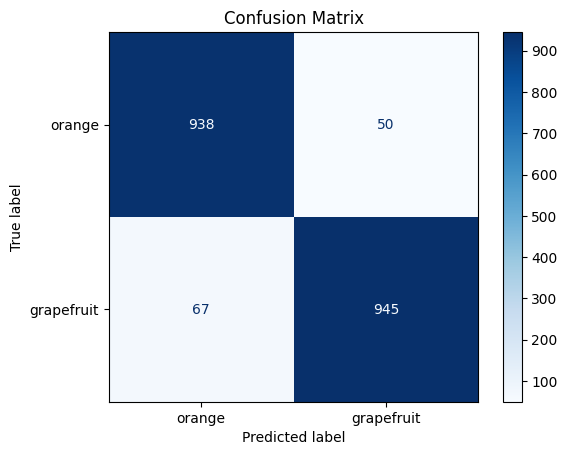

In [17]:
cm = confusion_matrix(y_test, y_pred)

labels = ['orange','grapefruit']

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [21]:
import pickle
fw = open('lr_fruit.pkl', 'wb')
pickle.dump(lr , fw)